In [61]:
import json
import os
from typing import List, Dict
import numpy as np
import networkx as nx
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import BettiCurve
import matplotlib.pyplot as plt
import gudhi as gd
from gtda.plotting import plot_diagram


In [62]:
def load_game_data(file_path: str) -> List[Dict]:
    with open(file_path, 'r') as file:
        game_data = json.load(file)
    return game_data

def load_all_games(data_dir: str) -> List[List[Dict]]:
    all_games = []
    goal_counts = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.json'):
            file_path = os.path.join(data_dir, filename)
            game = load_game_data(file_path)
            all_games.append(game)
            goal_counts.append(int(filename.split('_')[-1]) / int(filename.split('_')[-2]))
    return all_games, goal_counts

In [63]:
def construct_adjacency_matrix(game: List[Dict]) -> nx.Graph:
    G = nx.Graph()

    max_count = max(pass_info["count"] for player in game for pass_info in player["passes"]) + 1
    
    for player in game:
        G.add_node(player['name'], pos=(player['x'], player['y']))
    
    for player in game:
        for pass_info in player["passes"]:
            player1 = player["name"]
            player2 = pass_info["name"]
            count = pass_info["count"]
            edge_weight = max_count - count

            G.add_edge(player1, player2, weight=edge_weight)

    return G


def visualize_passing_network(G):
    pos = nx.get_node_attributes(G, 'pos')
    weights =nx.get_edge_attributes(G, 'weight').values()
    
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=list(weights), edge_color='gray')
    plt.title("Passing Network Graph")
    plt.axis('off')
    plt.show()
    

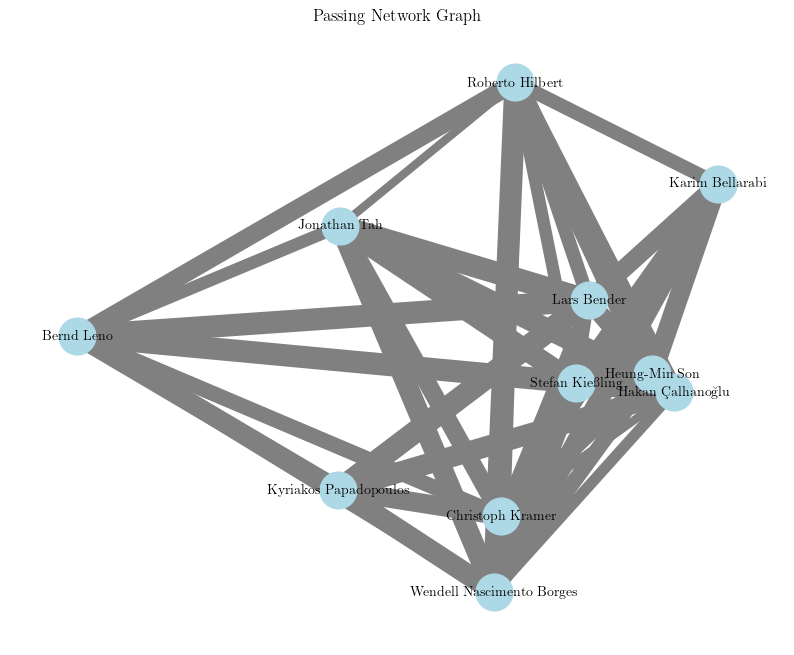

In [64]:
example_game = load_game_data('../data/2015-2016/1-Bundesliga/3890260_Bayer-Leverkusen_1_59.json')

G_example = construct_adjacency_matrix(example_game)
visualize_passing_network(G_example)

In [65]:
def graph_to_adjacency_matrix(G):
    nodes = sorted(G.nodes())
    adj_matrix_noinf = nx.to_numpy_array(G, nodelist=nodes, weight='weight')
    adj_matrix = np.where(adj_matrix_noinf == 0, np.inf, adj_matrix_noinf)
    np.fill_diagonal(adj_matrix, 0)
    return adj_matrix, nodes

In [66]:
adj_matrix, nodes = graph_to_adjacency_matrix(G_example)
print("Adjacency Matrix:")
print(adj_matrix)
print("\nNodes Order:")
print(nodes)

Adjacency Matrix:
[[ 0. 11. 16. inf  9. inf 14. 16. 13. 10. 10.]
 [11.  0.  6. 12. 13. 10. 14.  8. 13. inf  1.]
 [16.  6.  0. 12. 15. inf 15. 10. 14.  5.  8.]
 [inf 12. 12.  0. inf 14. inf 13. 16. 13. 11.]
 [ 9. 13. 15. inf  0. inf inf 16.  6. 15. 15.]
 [inf 10. inf 14. inf  0. inf 13. 10. 15. 14.]
 [14. 14. 15. inf inf inf  0. 16. inf inf 15.]
 [16.  8. 10. 13. 16. 13. 16.  0. 10.  8. 11.]
 [13. 13. 14. 16.  6. 10. inf 10.  0.  9. 16.]
 [10. inf  5. 13. 15. 15. inf  8.  9.  0. 14.]
 [10.  1.  8. 11. 15. 14. 15. 11. 16. 14.  0.]]

Nodes Order:
['Bernd Leno', 'Christoph Kramer', 'Hakan Çalhanoğlu', 'Heung-Min Son', 'Jonathan Tah', 'Karim Bellarabi', 'Kyriakos Papadopoulos', 'Lars Bender', 'Roberto Hilbert', 'Stefan Kießling', 'Wendell Nascimento Borges']


In [67]:
vr_persistence = VietorisRipsPersistence(
        metric="precomputed",
        homology_dimensions=[0, 1, 2, 3],  # Compute H0 and H1
        collapse_edges=True  # Handle disconnected graphs
    )

diagrams = vr_persistence.fit_transform([adj_matrix])[0]
plot_diagram(diagrams)

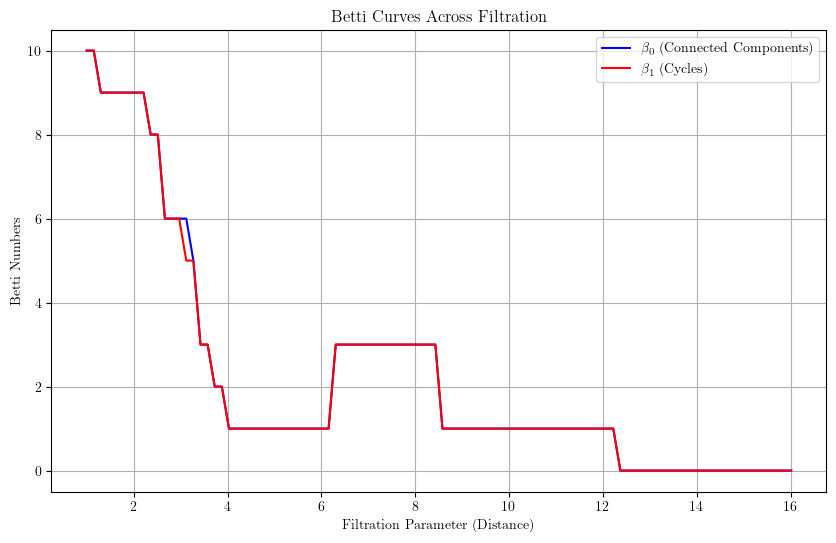

Betti 0 (Connected Components) at various filtration levels:
[10 10  9  9  9  9  9  9  9  8  8  6  6  6  6  5  3  3  2  2  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]

Betti 1 (Cycles) at various filtration levels:
[10 10  9  9  9  9  9  9  9  8  8  6  6  6  5  5  3  3  2  2  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]


In [ ]:
betti_transformer = BettiCurve(
    n_bins=100
)

betti_numbers = betti_transformer.fit_transform([diagrams])[0]

homology_dimensions = len(vr_persistence.homology_dimensions)
betti_numbers = betti_numbers.reshape(-1, homology_dimensions)

betti0 = betti_numbers[:, 0]
if homology_dimensions > 1:
    betti1 = betti_numbers[:, 1]
    if homology_dimensions > 2:
        betti2 = betti_numbers[:, 2]
else:
    betti1 = None

min_distance = np.min(adj_matrix[np.isfinite(adj_matrix) & (adj_matrix > 0)])
max_distance = np.max(adj_matrix[np.isfinite(adj_matrix)])
filtration_values = np.linspace(min_distance, max_distance, num=100)

plt.figure(figsize=(10, 6))
plt.plot(filtration_values, betti0, label=r'$\beta_0$ (Connected Components)', color='blue')
if betti1 is not None:
    plt.plot(filtration_values, betti1, label=r'$\beta_1$ (Cycles)', color='red')
plt.xlabel('Filtration Parameter (Distance)')
plt.ylabel('Betti Numbers')
plt.title('Betti Curves Across Filtration')
plt.legend()
plt.grid(True)
plt.show()

print("Betti 0 (Connected Components) at various filtration levels:")
print(betti0)

if betti1 is not None:
    print("\nBetti 1 (Cycles) at various filtration levels:")
    print(betti1)

In [69]:
auc_betti0 = np.trapz(betti0, filtration_values)
auc_betti1 = np.trapz(betti1, filtration_values) if betti1 is not None else 0
auc_betti2 = np.trapz(betti2, filtration_values) if betti2 is not None else 0
print(f"AUC β0: {auc_betti0}, AUC β1: {auc_betti1}")

AUC β0: 33.03030303030303, AUC β1: 32.87878787878788
